<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/repo/kprototypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install seaborn
!pip install kmodes
#!pip install plotnine

In [2]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import plotnine
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from plotnine import *

In [3]:
if str(pathlib.Path().absolute()).find('content') >= 0:
    sourcepath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Transformed'
else:
    sourcepath = '../Datos/Transformed'
print(sourcepath)    

https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Transformed


In [7]:
# Lee dataset estandarizado de transacciones
dfNoSupervisado1 = pd.read_csv("{}/transacciones.csv".format(sourcepath))

In [9]:
dfNoSupervisado1.AISLE = dfNoSupervisado1.AISLE.astype(str)

In [8]:
dfNoSupervisado1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16239 entries, 0 to 16238
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AISLE     16239 non-null  object 
 1   IG        16239 non-null  object 
 2   HTS       16239 non-null  object 
 3   PLANNING  16239 non-null  object 
 4   ABC       16239 non-null  object 
 5   UOM       16239 non-null  object 
 6   CAT       16239 non-null  object 
 7   COSTX     16239 non-null  float64
 8   QTYVAR    16239 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.1+ MB


In [10]:
dfNoSupervisado1.head()

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029976,-0.053250
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092472,-0.022999
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266130,0.004373
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.025112,-0.060323
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077982,-0.062534


In [11]:
# Posición de las variables categóricas
catColumnsPos = [dfNoSupervisado1.columns.get_loc(col) for col in list(dfNoSupervisado1.select_dtypes('object').columns)]
print('Categorical columns : {}'.format(list(dfNoSupervisado1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catColumnsPos))

Categorical columns : ['AISLE', 'IG', 'HTS', 'PLANNING', 'ABC', 'UOM', 'CAT']
Categorical columns position : [0, 1, 2, 3, 4, 5, 6]


In [12]:
# Posición de las variables numéricas]
numColumnsPos = [dfNoSupervisado1.columns.get_loc(col) for col in list(dfNoSupervisado1.select_dtypes('float64').columns)]
print('Numerical columns : {}'.format(list(dfNoSupervisado1.select_dtypes('float64').columns)))
print('Numerical columns position : {}'.format(numColumnsPos))

Numerical columns : ['COSTX', 'QTYVAR']
Numerical columns position : [7, 8]


In [13]:
numdf = dfNoSupervisado1[list(dfNoSupervisado1.select_dtypes('float64').columns)]

In [14]:
catdf = dfNoSupervisado1[list(dfNoSupervisado1.select_dtypes('object').columns)]

In [15]:
import numba as nb

In [16]:
from sklearn.metrics import silhouette_score
import time

dfNoSupervisado1.reset_index(drop=True)
N = dfNoSupervisado1.shape[0]

dataNum= dfNoSupervisado1.iloc[:,numColumnsPos]
dataNum=dataNum.to_numpy()
print('Datos numéricos',type(dataNum))

dataCat=dfNoSupervisado1.iloc[:,catColumnsPos]
dataCat=dataCat.to_numpy()
print('Datos categóricos',type(dataCat))

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

Datos numéricos <class 'numpy.ndarray'>
Datos categóricos <class 'numpy.ndarray'>


In [ ]:
@nb.njit
def dist_num_njit(data):
    scores = np.zeros((len(data),len(data)), dtype=np.float64)
    valor = nb.float64(0)

    for i in range(len(data)):
        for j in range(i+1, len(data)):
            valor = nb.float64(np.sum((data[i] - data[j]) ** 2))
            scores[i][j] = valor
    return scores

In [ ]:
def dist_cat(data, catWeight):
    scores = np.zeros((len(data),len(data)), dtype=np.float64)
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            scores[i][j] = np.float64(np.sum(data[i]!=data[j])*catWeight)
    return scores

In [ ]:
@nb.njit
def traspose_njit (data):
    scores = data
    for i in range(len(data)):
        for j in range(1+i,len(data)):
            scores[j][i] = scores[i][j]
    return scores            

In [ ]:
# Todavía no está implementado correctamente
def get_scores(data,catWeight):
    %time dist_num_np = dist_num_njit(dataNum[range(i)])
    %time dist_cat_np = dist_cat(dataCat[range(i)], catWeight)
    %time total = np.sum([dist_cat_np, dist_num_np], axis=0)
    %time total = traspose_njit(total)

In [ ]:
filename='NoCheck'
if not Path('{}/{}'.format(sourcepath,filename)).is_file():
    start_time = time.time()
    for i in [10, dataNum.shape[0]]:
        print('Número de filas a procesar: {}'.format(i))
        %time dist_num_np = dist_num_njit(dataNum[range(i)])
        %time dist_cat_np = dist_cat(dataCat[range(i)], catWeight)
        %time total = np.sum([dist_cat_np, dist_num_np], axis=0)
        %time total = traspose_njit(total)
        print()
#    %time np.savetxt('{}/{}'.format(sourcepath,filename),total, delimiter=',')  
    print('Tiempo total = {}'.format(time.time() - start_time))
else: 
    print('El archivo {} ya existe'.format(filename))

Número de filas a procesar: 10
CPU times: user 815 ms, sys: 14 ms, total: 829 ms
Wall time: 837 ms
CPU times: user 544 µs, sys: 99 µs, total: 643 µs
Wall time: 649 µs
CPU times: user 61 µs, sys: 12 µs, total: 73 µs
Wall time: 75.8 µs
CPU times: user 149 ms, sys: 1.79 ms, total: 151 ms
Wall time: 150 ms

Número de filas a procesar: 16239
CPU times: user 17.4 s, sys: 983 ms, total: 18.4 s
Wall time: 18.4 s
CPU times: user 23min 58s, sys: 3.46 s, total: 24min 2s
Wall time: 24min 5s
CPU times: user 2.2 s, sys: 4.01 s, total: 6.21 s
Wall time: 6.2 s
CPU times: user 1.96 s, sys: 12 ms, total: 1.97 s
Wall time: 1.96 s

Tiempo total = 1472.98459649086


In [ ]:
if len(total)>0:
    scores = pd.DataFrame(total)
else: 
    %time scores = pd.read_csv('{}/{}'.format(sourcepath,filename),header=None)

In [ ]:
scores.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16199,16200,16201,16202,16203,16204,16205,16206,16207,16208,16209,16210,16211,16212,16213,16214,16215,16216,16217,16218,16219,16220,16221,16222,16223,16224,16225,16226,16227,16228,16229,16230,16231,16232,16233,16234,16235,16236,16237,16238
16234,3.529040,3.506775,3.031217,3.529457,3.045818,9.084619,3.619747,6.947119,3.517221,3.519136,3.509757,4.697017,3.965023,3.608387,4.289107,3.019537,3.561895,3.632064,3.559337,2.525481,2.653236,2.879188,2.829525,2.987711,2.510489,2.523274,2.906053,2.960727,6.769502,3.526138,3.512488,3.532799,4.024338,3.518798,3.538302,3.538302,3.649621,3.019742,3.549994,3.012499,...,69.038275,71.277413,3.101295,9.399060,3.101326,3.385769,3.571288,3.106162,2.531910,3.500080,2.104227,2.010715,3.058916,3.065494,3.001644,2.657909,3.068026,3.486814,3.129351,2.544258,2.666350,3.002159,2.512892,3.073732,3.688534,2.563192,2.511509,2.671507,3.011403,0.508107,0.598017,0.836919,0.552023,0.500603,0.570512,0.000000,0.504306,1.464429,0.667910,0.541561
16235,3.550161,3.511825,3.013476,3.549940,3.073240,8.897817,3.666142,7.193398,3.508093,3.510232,3.511846,4.842009,4.056467,3.652732,4.406401,3.511775,3.594503,3.674434,3.533366,2.511822,2.606233,2.959030,2.903474,3.079051,2.516415,2.512713,2.988898,3.049355,7.009374,3.545519,3.520845,3.555330,4.119316,3.533454,3.519884,3.519884,3.695776,3.035278,3.579034,3.006551,...,67.976043,72.365808,2.643647,9.734119,3.144759,3.309651,3.673569,3.150389,2.016986,2.873137,2.139668,2.001436,3.086679,3.036213,3.000629,2.610062,3.038101,3.399549,3.171103,2.520954,2.715817,3.000367,2.511137,3.109899,3.583937,2.534506,2.003706,2.121938,3.001694,0.000596,0.631690,0.911776,0.077102,0.001686,0.594533,0.504306,0.000000,1.339952,0.717673,0.561720
16236,4.753847,4.488869,3.670329,4.745281,4.365574,7.043208,5.223882,11.547198,3.787303,4.293585,4.448773,7.782565,6.244814,5.181373,6.460489,4.311897,4.959390,5.183101,3.577253,3.227807,2.852018,4.990532,4.852761,5.270993,3.507229,3.273526,5.062307,5.203449,11.273781,4.725037,4.546030,4.778996,6.361849,4.646918,4.170205,4.170205,5.257246,4.160970,4.893858,3.829968,...,54.054719,88.469683,4.645082,15.326680,4.659694,3.155664,6.010161,4.676829,3.216929,2.501938,3.551652,2.772004,4.387176,3.527685,3.886511,2.842487,3.520602,3.081971,4.671135,3.095826,4.323497,3.875400,3.394950,4.524265,3.024527,3.034289,3.299236,2.834691,3.766269,1.295833,2.019006,2.873737,1.840144,1.416838,1.847163,1.464429,1.339952,0.000000,2.329491,1.756114
16237,3.558992,3.634796,3.291519,3.559681,3.038450,11.076334,3.508572,5.741996,3.720076,3.715213,3.646751,4.026483,3.604877,3.510769,3.764763,3.705038,3.526091,3.503173,3.852802,2.752253,3.083242,2.552523,2.533960,2.600357,2.625326,2.724904,2.563536,2.587689,5.598194,3.564656,3.611984,3.553603,3.618690,3.582963,3.786193,3.786193,3.500756,3.079572,3.534663,3.199508,...,74.835410,65.627573,3.010861,7.725348,3.013858,3.933813,3.170246,3.012221,2.756565,4.360727,2.011908,2.250328,3.031095,3.410681,3.197637,3.101086,3.416607,4.138042,3.003726,2.857897,2.500005,3.202256,2.667365,3.020203,4.431240,2.905235,2.719354,3.099800,3.253283,0.738389,0.015030,0.536559,0.538370,0.685524,0.038472,0.667910,0.717673,2.329491,0.000000,0.553876
16238,3.502744,3.519995,3.095380,3.502012,3.004875,10.089298,3.541131,6.471362,3.556539,3.553845,3.523434,4.407695,3.795086,3.535598,4.050768,3.548734,3.510608,3.531638,3.630942,2.573140,2.782704,2.709789,2.670972,2.797147,2.515675,2.558639,2.731126,2.775156,6.305537,3.502580,3.511316,3.502627,3.827758,3.504470,3.591724,3.591724,3.542229,3.004027,3.506508,3.046668,...,71.043004,69.251580,3.029672,8.759884,3.034217,3.542104,3.393630,3.035881,2.575304,3.783230,1.516555,1.577282,3.003357,3.168880,3.052999,2.795468,3.172595,3.696930,3.030064,2.636642,2.552862,3.054945,2.531540,3.016690,3.930553,2.165482,2.557377,2.794256,2.578761,0.571420,0.513600,0.676694,0.501405,0.548097,0.503862,0.541561,0.561720,1.75611

In [ ]:
cost = []
silueta = []
start_time = time.time()

for k in (range(1,11)):
# try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
        silhouette_coeff = silhouette_score(scores, kprototype.labels_, metric='precomputed')
        silueta.append(silhouette_coeff)
        print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
        print(silhouette_coeff)
    # except:
    #     break

k: 1
--- 25.784171104431152 seconds ---
k: 2
--- 155.47565245628357 seconds ---
Coeficiente silueta --- 157.4416880607605 seconds ---
0.7368588147337156
k: 3
--- 301.37263226509094 seconds ---
Coeficiente silueta --- 303.3049330711365 seconds ---
0.7182825853232915
k: 4
--- 445.10995411872864 seconds ---
Coeficiente silueta --- 446.8572554588318 seconds ---
0.10914930712265486
k: 5
--- 605.5318839550018 seconds ---
Coeficiente silueta --- 607.7339978218079 seconds ---
0.1391253039621705
k: 6
--- 772.4207117557526 seconds ---
Coeficiente silueta --- 774.1850960254669 seconds ---
0.16195435391945107
k: 7
--- 988.3748071193695 seconds ---
Coeficiente silueta --- 990.1095027923584 seconds ---
0.14642970918022294
k: 8
--- 1210.0122094154358 seconds ---
Coeficiente silueta --- 1211.7230401039124 seconds ---
0.15780128213560415
k: 9
--- 1446.8321998119354 seconds ---
Coeficiente silueta --- 1448.532114982605 seconds ---
0.1427476758851263
k: 10
--- 1729.841406583786 seconds ---
Coeficiente si

In [ ]:
silueta

[0.7368588147337156,
 0.7182825853232915,
 0.10914930712265486,
 0.1391253039621705,
 0.16195435391945107,
 0.14642970918022294,
 0.15780128213560415,
 0.1427476758851263,
 0.16567644534445009]

In [ ]:
df_cost = pd.DataFrame({'Cluster':range(1,11), 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':range(2,11), 'Coeficiente':silueta})
silueta

[0.7368588147337156,
 0.7182825853232915,
 0.10914930712265486,
 0.1391253039621705,
 0.16195435391945107,
 0.14642970918022294,
 0.15780128213560415,
 0.1427476758851263,
 0.16567644534445009]

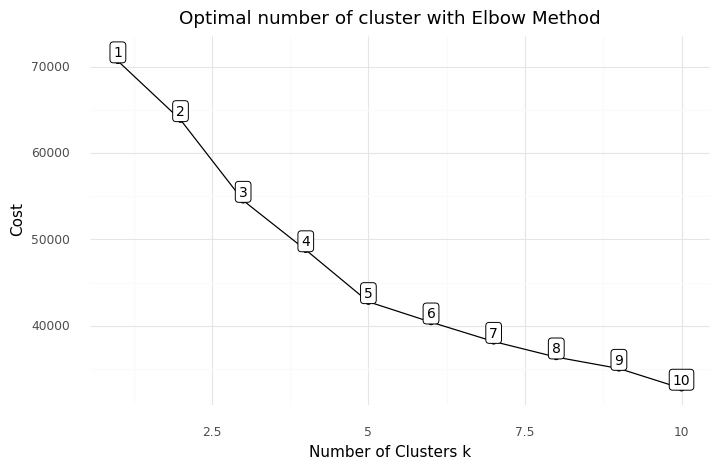

<ggplot: (8767919799289)>

In [ ]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

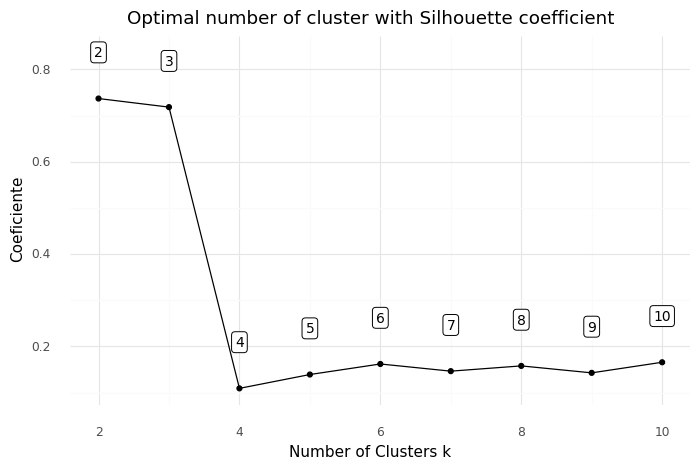

<ggplot: (8767910237177)>

In [ ]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)

In [ ]:
dfNoSupervisado1.head()

,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029976,-0.053250
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092472,-0.022999
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266130,0.004373
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.025112,-0.060323
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077982,-0.062534


In [ ]:
# Fit the cluster 
k = 2
gamma = 0.5
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = gamma, random_state = 0)
kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 90.74455618858337 seconds ---


In [ ]:
dfNoSupervisado1['Cluster'] = kprototype.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


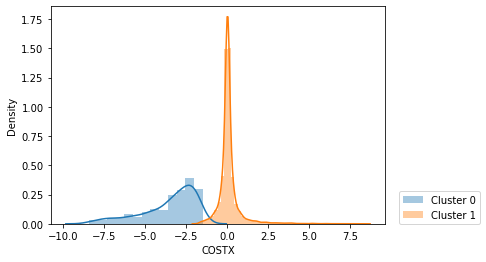

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


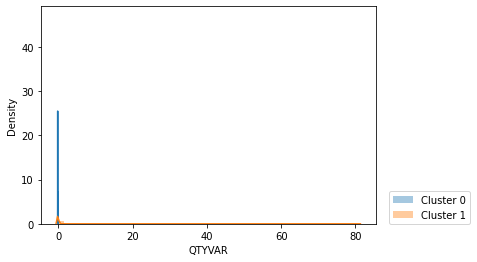

In [ ]:
import matplotlib.pylab as plt
for var in ['COSTX','QTYVAR']:
    for i in range(k):
        sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,var], label= 'Cluster {}'.format(i));
        plt.legend(loc=(1.04,0))
    plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


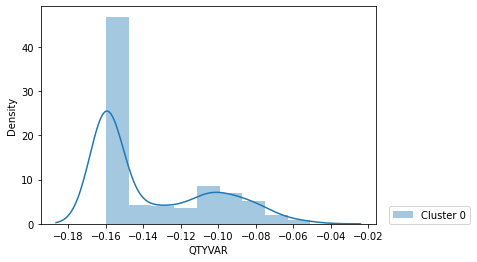

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


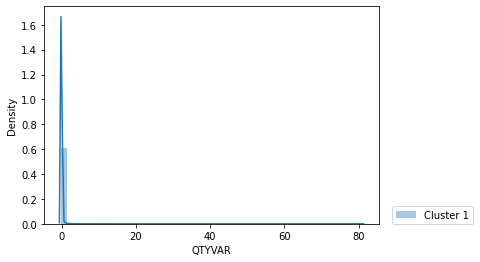

In [ ]:
for i in range(k):
    sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,'QTYVAR'], label= 'Cluster {}'.format(i));
    plt.legend(loc=(1.04,0))
    plt.show()